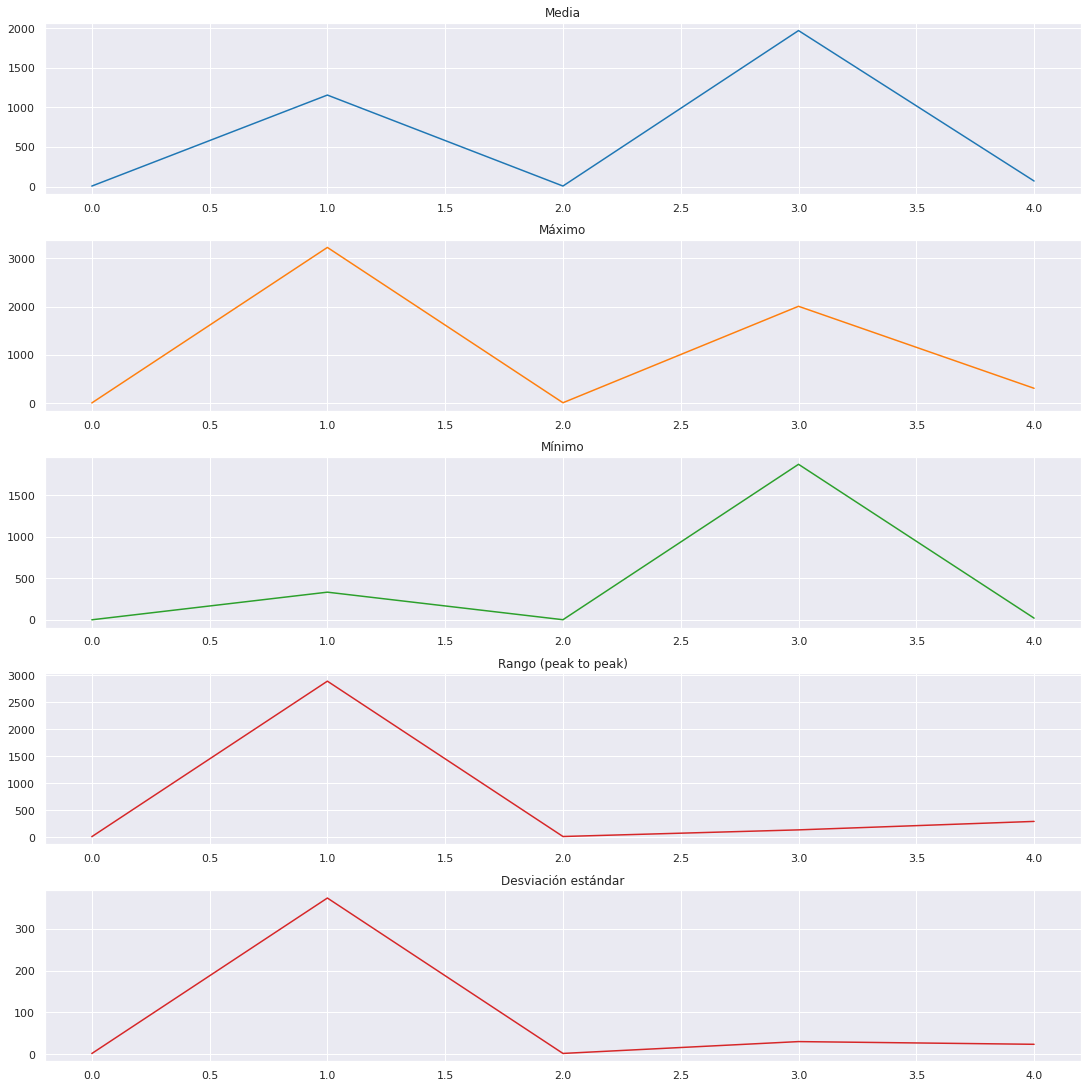

In [68]:
##Carga de librerias
import numpy as np
import numpy.ma as ma
from sklearn.linear_model import LinearRegression
import seaborn as sbn
import matplotlib.pyplot as plt

#Carga de dataset y división de dataset
data = np.load('proyecto_training_data.npy')
training_data = data[:1168]
test_data = data[1169:]

#Análisis exploratorio de datos
mean_training_data = np.nanmean(training_data[:,1:],axis=0)
max_training_data = np.nanmax(training_data[:,1:],axis=0)
min_training_data = np.nanmin(training_data[:,1:],axis=0)
ptp_training_data = np.nanmax(training_data[:,1:],axis=0) - np.nanmin(training_data[:,[1,2,3,4,5]],axis=0)
std_traning_data = np.nanstd(training_data[:,1:],axis=0)

fig, axs = plt.subplots(5, 1,constrained_layout = True)
axs[0].plot(mean_training_data, 'tab:blue')
axs[0].set_title('Media')
axs[1].plot(max_training_data, 'tab:orange')
axs[1].set_title('Máximo')
axs[2].plot(min_training_data, 'tab:green')
axs[2].set_title('Mínimo')
axs[3].plot(ptp_training_data, 'tab:red')
axs[3].set_title('Rango (peak to peak)')
axs[4].plot(std_traning_data, 'tab:red')
axs[4].set_title('Desviación estándar')
fig.set_size_inches(15, 15)
plt.show()



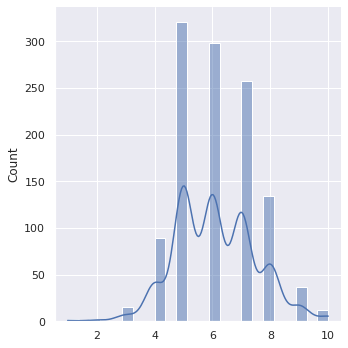

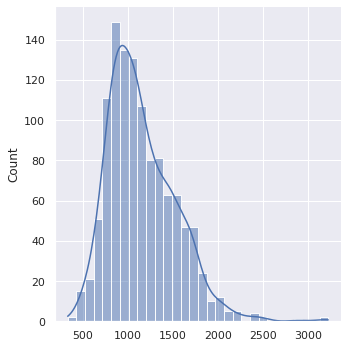

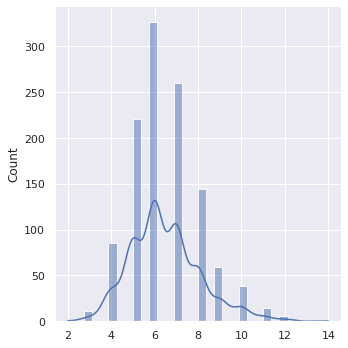

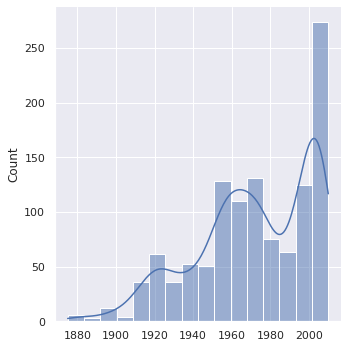

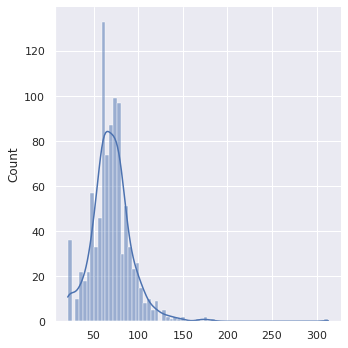

In [69]:
#Obtener columnas de datos
x1 = training_data[:, 0]
x2 = training_data[:, 1]
x3 = training_data[:, 2]
x4 = training_data[:, 3]
x5 = training_data[:, 4]
x6 = training_data[:, 5]

sbn.set_theme(); 
ax = sbn.displot(x2, kde=True)
ax = sbn.displot(x3, kde=True)
ax = sbn.displot(x4, kde=True)
ax = sbn.displot(x5, kde=True)
ax = sbn.displot(x6, kde=True)

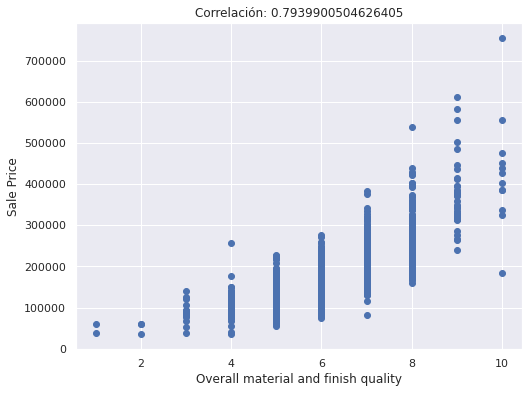

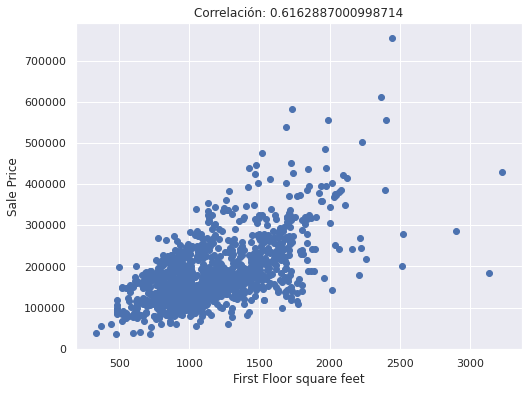

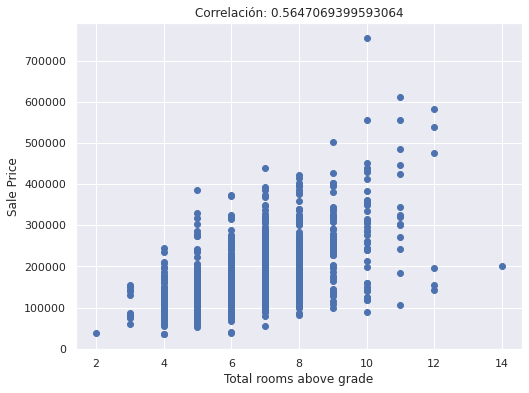

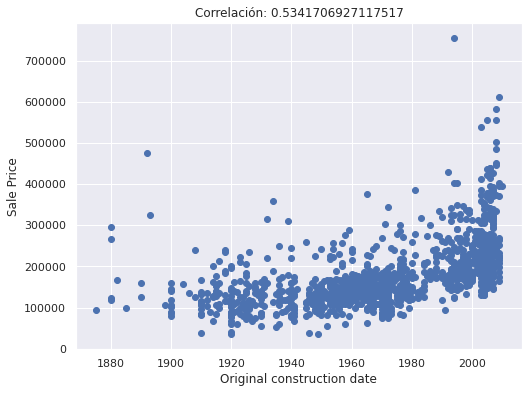

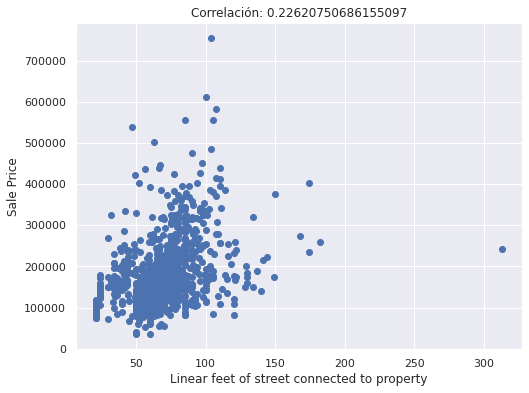

In [70]:
#Obtener correlación entre variables y valor de y (Precio de venta)

corrcoef1 = np.corrcoef(x1,x2)[0][1]
corrcoef2 = np.corrcoef(x1,x3)[0][1]
corrcoef3 = np.corrcoef(x1,x4)[0][1]
corrcoef4 = np.corrcoef(x1,x5)[0][1]
corrcoef5 = np.corrcoef(x1,np.nan_to_num(x6))[0][1]

plt.rcParams['figure.figsize'] = 8, 6
plt.scatter(x2,x1)
plt.xlabel('Overall material and finish quality')
plt.ylabel('Sale Price')
plt.title('Correlación: '  + str(corrcoef1))
plt.show()
plt.scatter(x3,x1)
plt.title('Correlación: '  + str(corrcoef2))
plt.ylabel('Sale Price')
plt.xlabel('First Floor square feet')
plt.show()
plt.scatter(x4,x1)
plt.title('Correlación: '  + str(corrcoef3))
plt.ylabel('Sale Price')
plt.xlabel('Total rooms above grade')
plt.show()
plt.scatter(x5,x1)
plt.title('Correlación: '  + str(corrcoef4))
plt.ylabel('Sale Price')
plt.xlabel('Original construction date')
plt.show()
plt.scatter(x6,x1)
plt.title('Correlación: '  + str(corrcoef5))
plt.ylabel('Sale Price')
plt.xlabel('Linear feet of street connected to property')
plt.show()

In [71]:
##Seleccionando variables
correlacion = {'x2': corrcoef1,'x3': corrcoef2,'x4': corrcoef3,'x5': corrcoef4, 'x6': corrcoef5}
mejorCorrelacion = sorted(correlacion.items(), key=lambda x: x[1], reverse=True)
print(mejorCorrelacion)


[('x2', 0.7939900504626405), ('x3', 0.6162887000998714), ('x4', 0.5647069399593064), ('x5', 0.5341706927117517), ('x6', 0.22620750686155097)]


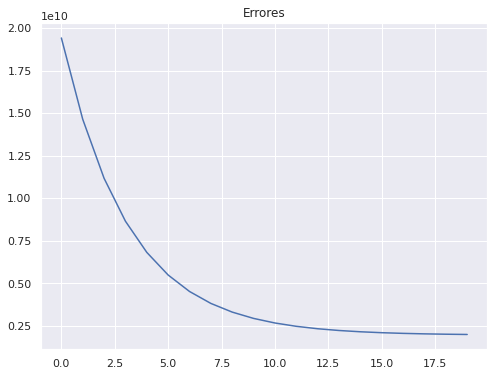

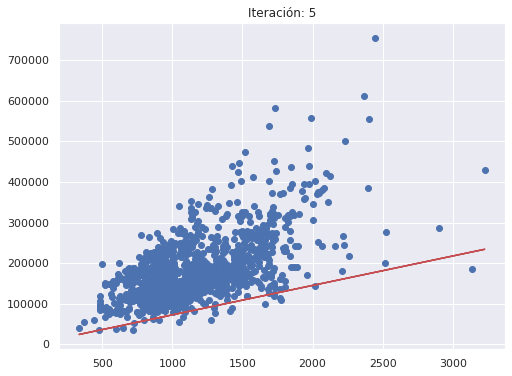

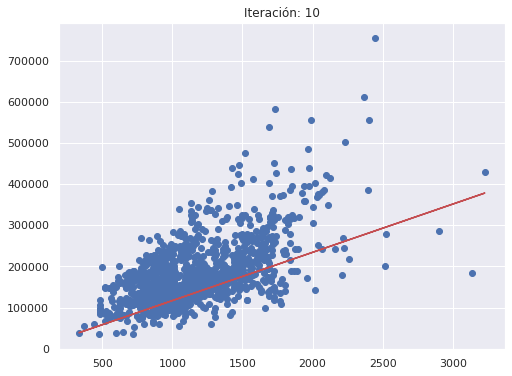

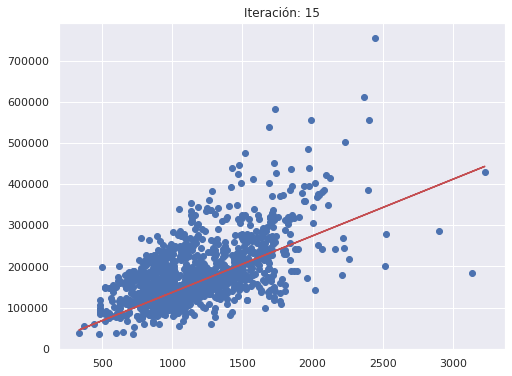

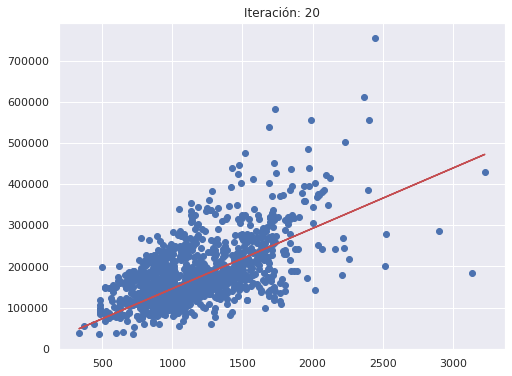

In [72]:
#Definición de la función para cálculo manual

def regresionManual(x,y,epoch,imprimir_error_cada, lr, param=[0,0]):
  errores = []
  ones = np.ones_like(x)
  matriz = np.stack((x,ones),axis=-1)
  dic = {}
  for a in range(0, epoch):
    dic[a+1] = np.array(param)
    yhat = np.matmul(matriz,param)
    dic[a+1] = [np.array(param),yhat]
    error = 0.5* np.mean(np.power((yhat-y),2))
    errores.append(error)
    restayhaty = yhat-y
    matrizGradientes = matriz * restayhaty.reshape(len(restayhaty),1)
    matrizGradientes = matrizGradientes.mean(axis=0)
    param = param - (lr * matrizGradientes)
    if(imprimir_error_cada > 0):
      if (a+1) % imprimir_error_cada == 0:
        print(error)
    
  return dic, errores

def plotErrores(Errores):
  plt.title('Errores')
  plt.plot(Errores)
  plt.show()

def plotModeloEntrenado(resultadoDic, n, training_data, salePrice):
  for (key,value) in resultadoDic.items():
    if(key%n) == 0:
      plt.scatter(training_data, salePrice, marker='o')
      plt.plot(training_data, value[1],color="r")
      plt.title('Iteración: ' + str(key))
      plt.show();
  

resultadoDic, resultadoErrores = regresionManual(x3,x1,20,100,0.0000001,[0,0])
plotErrores(resultadoErrores)

plotModeloEntrenado(resultadoDic, 5, x3,x1)




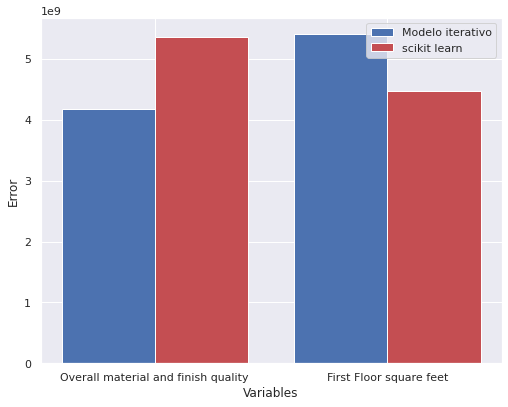

In [73]:
#Regresión con scikit-learn

def regresionsklearn(x,y):
  x = x.reshape(-1,1)
  y = y.reshape(-1,1)
  reg = LinearRegression()
  reg.fit(x,y)
  y_pred = reg.predict(x)
  return y_pred

def regresionLineal(x,y, epoch, lr, param=[0,0]):
  dicyrm, errores = regresionManual(x,y,epoch,0,lr,param)
  y_rm = dicyrm[epoch][1].reshape(len(dicyrm[epoch][1]),1)
  y_predsk = regresionsklearn(x,y)
  matrix = np.hstack((y_rm,y_predsk))
  matrix = matrix.mean(axis=1)
  return y_rm, y_predsk, matrix

#Calcular para las variables independientes modelo manual y modelo sklearn y obtener promedio
y1_m, y1_sk, y1_mean = regresionLineal(x2,x1,80,0.001,[0,0])
y2_m, y2_sk, y2_mean = regresionLineal(x3,x1,20,0.0000001,[0,0])

#Calcular para las variables independientes modelo manual y modelo sklearn y obtener promedio de datos de validación 
#Obtener variables 
x_test2 = test_data[:, 1]
x_test3 = test_data[:, 2]
y = test_data[:,0]

y1_m_test, y1_sk_test, y1_mean_test = regresionLineal(x_test2,y,80,0.001,[0,0])
y2_m_test, y2_sk_test, y2_mean_test = regresionLineal(x_test3,y,20,0.0000001,[0,0])

error1_m  = 0.5* np.mean(np.power((y-y1_m_test),2))
error1_sk = 0.5* np.mean(np.power((y-y1_sk_test),2)) 
error2_m  = 0.5* np.mean(np.power((y-y2_m_test),2))
error2_sk = 0.5* np.mean(np.power((y-y2_sk_test),2))

erroresx2 = [error1_m,error1_sk]
erroresx3 = [error2_m,error2_sk]
x = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x-0.2,erroresx2,0.40, color='b')
ax.bar(x+0.2,erroresx3,0.40, color='r')
ax.set_xticks([0,1])
ax.set_xticklabels(['Overall material and finish quality', 'First Floor square feet'])
plt.xlabel("Variables")
plt.ylabel("Error")
plt.legend(["Modelo iterativo", "scikit learn"])
plt.show()

##Conclusión
Para la variable "Overall material and finish quality" el modelo iterativo presento el error más bajo.

Para la variable "First Floor square feet" el modelo con scikit learn presento el error más bajo.